本文是上一个策略“机器学习-动态因子选择策略”的详细分析讲解篇

欢迎访问我的Github: https://github.com/charliedream1/ai_quant_trade

策略说明：
问题：如果回测某个区间最大回撤很大，说明这个时间点选取的因子可能不合适，如何自动判断因子重要性，并选择？

因子选择：
- 基本面因子：https://www.joinquant.com/help/api/help#name:Stock
- 技术分析指标因子：https://www.joinquant.com/help/api/help#name:technicalanalysis

策略思路
1. 因子筛选：通过基本面和技术面人工选择需要使用的因子
2. 训练决策树：对长周期收益增加的打标签1，否则0。对收益进行分类。之后，按照因子的重要性，选择top的因子
3. 训练回归支持向量机：使用挑选的重要因子训练。真实市值和模型预测的市值差，找到预测和真实值差值最小的选择购买

实验结论：
1. 特征选择：(a)随机森林比决策树性能好 (b)特征选择过多效果并不如挑选几个重要的特征, 测试使用10个特征性能 > 20个  > 大于使用所有 (c) 使用随机森林对特征重要性选择，n_estimators越大，回归模型性能越好 (d)
2. 市值回归预测：(a)随机森林 > 线性核的SVR (b) rbf核和DNN的score为负数

In [1]:
from jqlib.technical_analysis import *
from jqdata import *

# 2. 导入其它库
import datetime
import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# 1. 基本数据情况分析

In [2]:
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
five_days_ago = today - datetime.timedelta(days = 5)
today, yesterday, five_days_ago

(datetime.date(2022, 6, 28),
 datetime.date(2022, 6, 27),
 datetime.date(2022, 6, 23))

In [3]:
# 使用的股票池，使用沪深300
ref_index_stock = '000300.XSHG'
# 获取大盘收盘价
hs300_close = get_price(ref_index_stock, five_days_ago, today, fq='pre')['close']
hs300_close.head()

2022-06-23    4343.88
2022-06-24    4394.77
2022-06-27    4444.26
2022-06-28    4444.26
Name: close, dtype: float64

In [4]:
# 大盘相对5天前涨幅
hs300_ret = hs300_close[-1] / hs300_close[0] - 1
hs300_ret

0.023108373159479667

In [5]:
close_data = attribute_history(ref_index_stock, 100, '1d', ['close'], df=False)
# 设定均线
n1 = 5
n2 = 20
n3 = 125
# 取得过去5个交易日的平均收盘价
ma_n1 = close_data['close'][-n1:].mean()
# 取得过去20个交易日的平均收盘价
ma_n2 = close_data['close'][-n2:].mean()
# 取得过去125个交易日的平均收盘价
ma_n3 = close_data['close'][-n3:].mean()
# 取得上一时间点价格
current_price = close_data['close'][-1]
print('current_price', current_price)
print('ma_5days', ma_n1)
print('ma_20days', ma_n2)
print('ma_125days', ma_n3)

current_price 4444.26
ma_5days 4355.82
ma_20days 4231.574500000001
ma_125days 4254.344700000001


In [6]:
# 获取沪深300股票列表
hs300_stock_lst = get_index_stocks('000300.XSHG')
hs300_stock_lst[:10]

['000001.XSHE',
 '000002.XSHE',
 '000063.XSHE',
 '000066.XSHE',
 '000069.XSHE',
 '000100.XSHE',
 '000157.XSHE',
 '000166.XSHE',
 '000301.XSHE',
 '000333.XSHE']

# 2. 数据获取

##  1.1 加载基本面因子数据

In [7]:
# 创建query对象，指定获取股票的代码、市值、净运营资本
# 净债务、产权比率、股东权益比率、营收增长率、换手率、
# 市盈率（PE）、市净率（PB）、市销率（PS）、总资产收益率因子
q = query(valuation.code, valuation.market_cap,
          balance.total_current_assets - balance.total_current_liability,
          balance.total_liability - balance.total_assets,
          balance.total_liability / balance.equities_parent_company_owners,
          (balance.total_assets - balance.total_current_assets) / balance.total_assets,
          balance.equities_parent_company_owners / balance.total_assets,
          indicator.inc_total_revenue_year_on_year,
          valuation.turnover_ratio,
          valuation.pe_ratio,
          valuation.pb_ratio,
          valuation.ps_ratio, indicator.roa).filter(
    valuation.code.in_(hs300_stock_lst))
# 将获得的因子值存入一个数据表
df = get_fundamentals(q, date=None)
df.head()

,code,market_cap,anon_1,anon_2,anon_3,anon_4,anon_5,inc_total_revenue_year_on_year,turnover_ratio,pe_ratio,pb_ratio,ps_ratio,roa
0,000001.XSHE,2811.9175,NaN,-4.061748e+11,11.600355,NaN,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26
1,000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14
2,000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17
3,000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32
4,000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09


In [8]:
# 把数据表的字段名指定为对应的因子名
df.columns = ['code', '市值', '净营运资本',
              '净债务', '产权比率', '非流动资产比率',
              '股东权益比率', '营收增长率'
    , '换手率', 'PE', 'PB', 'PS', '总资产收益率']
# 将股票代码作为数据表的index
df.index = df.code.values
# 使用del也可以删除列
del df['code']
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率
000001.XSHE,2811.9175,NaN,-4.061748e+11,11.600355,NaN,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26
000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14
000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17
000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32
000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09


In [9]:
# 主要时间点设定
today = datetime.date.today()
# 设定2个时间差，分别是50天，1天
delta50 = datetime.timedelta(days=50)
delta1 = datetime.timedelta(days=1)
# 50日前作为一个历史节点
history_50ds = today - delta50
# 再计算昨天的日期
yesterday = today - delta1
yesterday, history_50ds

(datetime.date(2022, 6, 27), datetime.date(2022, 5, 9))

## 1.2 获取最新的技术因子

In [10]:
# 下面就获取股票的动量线、成交量、累计能量线、平均差、
# 指数移动平均、移动平均、乖离率等因子
# 时间范围都设为10天
df['动量线'] = list(MTM(df.index, yesterday,
                     timeperiod=10, unit='1d',
                     include_now=True,
                     fq_ref_date=None).values())
df['成交量'] = list(VOL(df.index, yesterday, M1=10,
                     unit='1d', include_now=True,
                     fq_ref_date=None)[0].values())
df['累计能量线'] = list(OBV(df.index, check_date=yesterday,
                       timeperiod=10).values())
df['平均差'] = list(DMA(df.index, yesterday, N1=10,
                     unit='1d', include_now=True,
                     fq_ref_date=None)[0].values())
df['指数移动平均'] = list(EMA(df.index, yesterday, timeperiod=10,
                        unit='1d', include_now=True,
                        fq_ref_date=None).values())
df['移动平均'] = list(MA(df.index, yesterday, timeperiod=10,
                     unit='1d', include_now=True,
                     fq_ref_date=None).values())
df['乖离率'] = list(BIAS(df.index, yesterday, N1=10,
                      unit='1d', include_now=True,
                      fq_ref_date=None)[0].values())
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率
000001.XSHE,2811.9175,NaN,-4.061748e+11,11.600355,NaN,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26,0.58,1497278.18,668914281.0,-0.3986,14.308895,14.346,1.003764
000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14,1.04,700741.92,192617757.0,-0.3240,18.316412,18.330,0.981997
000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17,0.49,390225.97,57165038.0,1.5648,25.099482,25.285,-0.375717
000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32,-0.09,260702.03,55492859.0,0.5460,10.561782,10.581,0.841130
000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09,0.48,896021.57,418744306.0,-0.2518,5.657840,5.630,3.374778


In [11]:
# 把数据表中的空值用0来代替
df.fillna(0, inplace=True)
#获取股票前一日的收盘价
df['close1']=list(get_price(hs300_stock_lst, 
                       end_date=yesterday, 
                       count = 1,
                       fq='pre',panel=False)['close'])
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率,close1
000001.XSHE,2811.9175,0.000000e+00,-4.061748e+11,11.600355,0.000000,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26,0.58,1497278.18,668914281.0,-0.3986,14.308895,14.346,1.003764,14.49
000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14,1.04,700741.92,192617757.0,-0.3240,18.316412,18.330,0.981997,18.51
000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17,0.49,390225.97,57165038.0,1.5648,25.099482,25.285,-0.375717,25.19
000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32,-0.09,260702.03,55492859.0,0.5460,10.561782,10.581,0.841130,10.67
000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09,0.48,896021.57,418744306.0,-0.2518,5.657840,5.630,3.374778,5.82


In [12]:
#获取股票50日前的收盘价
df['close2']=list(get_price(hs300_stock_lst,  
                       end_date=history_50ds, 
                       count = 1,
                       fq ='pre',panel=False)['close'])
df.tail()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率,close1,close2
688363.XSHG,678.2821,2.528823e+09,-6.011806e+09,0.233262,0.519220,0.810948,61.57,6.8649,81.7513,11.7413,12.5007,2.65,0.09,65843.71,5451705.0,10.8510,143.272482,143.857,-1.992951,140.99,122.52
688396.XSHG,752.4524,1.165588e+10,-1.811441e+10,0.289148,0.329126,0.768991,22.94,1.8395,30.2507,4.2545,7.7426,2.68,-2.02,81142.24,-18673996.0,5.5240,57.125812,57.595,-1.033076,57.00,46.41
688561.XSHG,370.6434,4.786264e+09,-9.395928e+09,0.376994,0.398691,0.725508,44.52,0.5683,-74.2944,3.9501,6.1649,-3.65,3.72,26110.62,7636315.0,3.2508,53.349821,53.152,2.235099,54.34,47.19
688599.XSHG,1462.9047,7.070663e+09,-2.278407e+10,2.332285,0.293511,0.293731,79.20,1.7271,69.0945,7.0865,2.8555,0.85,7.29,228419.06,149939021.0,5.1096,64.319386,62.578,7.849404,67.49,52.80
688981.XSHG,3575.3213,7.224635e+10,-1.672907e+11,0.630879,0.574801,0.471422,62.56,0.8819,28.5013,3.1852,8.8955,1.55,-0.54,165006.97,29096119.0,2.1994,44.927543,45.083,0.259521,45.20,39.93


In [13]:
# 把数据表中的空值用0来代替
df.fillna(0, inplace=True)
# 计算出收益, 昨天收盘价相对50天前涨跌幅
df['return'] = df['close1'] / df['close2'] - 1
#检查是否成功
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率,close1,close2,return
000001.XSHE,2811.9175,0.000000e+00,-4.061748e+11,11.600355,0.000000,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26,0.58,1497278.18,668914281.0,-0.3986,14.308895,14.346,1.003764,14.49,14.55,-0.004124
000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14,1.04,700741.92,192617757.0,-0.3240,18.316412,18.330,0.981997,18.51,18.48,0.001623
000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17,0.49,390225.97,57165038.0,1.5648,25.099482,25.285,-0.375717,25.19,22.86,0.101925
000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32,-0.09,260702.03,55492859.0,0.5460,10.561782,10.581,0.841130,10.67,9.79,0.089888
000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09,0.48,896021.57,418744306.0,-0.2518,5.657840,5.630,3.374778,5.82,5.64,0.031915


In [14]:
# 如果收益大于平均水平，则标记为1, 否则标记为0
df['signal']=np.where(df['return']<df['return'].mean(),0,1)
#检查是否成功
df.head()

,市值,净营运资本,净债务,产权比率,非流动资产比率,股东权益比率,营收增长率,换手率,PE,PB,PS,总资产收益率,动量线,成交量,累计能量线,平均差,指数移动平均,移动平均,乖离率,close1,close2,return,signal
000001.XSHE,2811.9175,0.000000e+00,-4.061748e+11,11.600355,0.000000,0.079363,10.57,0.7716,7.2001,0.8363,1.6179,0.26,0.58,1497278.18,668914281.0,-0.3986,14.308895,14.346,1.003764,14.49,14.55,-0.004124,0
000002.XSHE,2151.8584,3.048454e+11,-3.933097e+11,6.560801,0.173873,0.121636,0.65,0.7211,9.4960,0.9085,0.4748,0.14,1.04,700741.92,192617757.0,-0.3240,18.316412,18.330,0.981997,18.51,18.48,0.001623,0
000063.XSHE,1192.6785,5.743872e+10,-5.531577e+10,2.306207,0.226818,0.299797,6.43,1.0023,17.4166,2.2699,1.0263,1.17,0.49,390225.97,57165038.0,1.5648,25.099482,25.285,-0.375717,25.19,22.86,0.101925,0
000066.XSHE,344.1928,9.296436e+09,-1.468575e+10,1.436590,0.370459,0.397642,-9.24,0.8867,53.8264,2.5271,1.9665,-0.32,-0.09,260702.03,55492859.0,0.5460,10.561782,10.581,0.841130,10.67,9.79,0.089888,0
000069.XSHE,477.3444,1.471469e+11,-1.244737e+11,4.345297,0.196149,0.170275,-12.56,1.2700,15.5290,0.6153,0.4702,0.09,0.48,896021.57,418744306.0,-0.2518,5.657840,5.630,3.374778,5.82,5.64,0.031915,0


## 1.3 机器学习数据准备

In [15]:
# 把因子值作为样本的特征，所以要去掉刚刚添加的几个字段
x = df.drop(['close1', 'close2', 'return', 'signal'], axis=1)
# 把signal作为分类标签
y = df['signal']
x = x.fillna(0)
y = y.fillna(0)

# 2. 机器学习

## 2.1 决策树特征筛选

In [16]:
#导入数据集拆分工具
from sklearn.model_selection import train_test_split
#导入决策树分类器
from sklearn.tree import DecisionTreeClassifier

In [17]:
#将数据拆分为训练集和验证集
X_train,X_test,y_train,y_test=\
train_test_split(x,y,test_size = 0.3)
#创建决策树分类器实例，指定random_state便于复现
clf = DecisionTreeClassifier(random_state=1000)
#拟合训练集数据
clf.fit(X_train, y_train)
#查看分类器在训练集和验证集中的准确率
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.8


In [18]:
# 根据重要性，进行特征筛选。输出2列，因子名和重要性
factor_weight = pd.DataFrame({'features':list(x.columns),
                             'importance':clf.feature_importances_}).sort_values(
    #这里根据重要程度降序排列，一遍遍找到重要性最高的特征
    by='importance', ascending = False)
#检查结果
factor_weight

,features,importance
15,平均差,0.578145
6,营收增长率,0.085790
16,指数移动平均,0.084030
7,换手率,0.065497
18,乖离率,0.052255
1,净营运资本,0.051007
8,PE,0.025057
13,成交量,0.019973
9,PB,0.013911
10,PS,0.010433


## 2.2 随机森林--特征重要性筛选

In [19]:
from sklearn.ensemble import RandomForestClassifier
#创建随机森林分类器实例，指定random_state便于复现
# n_estimators约大，性能越好，但运行时间也越长
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
#拟合训练集数据
forest.fit(X_train, y_train)
#查看分类器在训练集和验证集中的准确率
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))
# 可以看到测试的准确性比决策树要高很多

1.0
0.8333333333333334


In [20]:
# 根据重要性，进行特征筛选。输出2列，因子名和重要性
factor_weight = pd.DataFrame({'features':list(x.columns),
                             'importance':forest.feature_importances_}).sort_values(
    #这里根据重要程度降序排列，一遍遍找到重要性最高的特征
    by='importance', ascending = False)
#检查结果，可以看到重要性和决策树略有差异
factor_weight

,features,importance
15,平均差,0.290277
12,动量线,0.098558
18,乖离率,0.065764
9,PB,0.059026
17,移动平均,0.054337
16,指数移动平均,0.047897
7,换手率,0.044507
6,营收增长率,0.044127
8,PE,0.040370
10,PS,0.034475


In [21]:
factor_weight.shape

(19, 2)

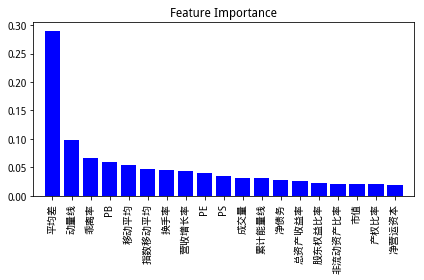

In [22]:
# 绘制特征重要性图像
plt.title('Feature Importance')
# 特征数量 和 特征重要性
plt.bar(range(factor_weight.shape[0]), factor_weight['importance'], color='blue', align='center')
# 横轴特征名
plt.xticks(range(factor_weight.shape[0]), factor_weight['features'], rotation=90)
           # fontdict={'color':'red', 'size':16})
plt.xlim([-1, factor_weight.shape[0]])
plt.tight_layout()

# 3. 回归模型预测--市值预测

## 3.1 支持向量机训练及预测

In [23]:
# 选出最重要的10个特征
features = factor_weight['features'][:10]
x_new = df[features]
y_new = df['市值']
x_new = x_new.fillna(0)
y_new = y_new.fillna(0)

#将数据拆分为训练集和验证集
x_new_train,x_new_test,y_new_train,y_new_test=\
train_test_split(x_new,y_new,test_size = 0.2)

#对数据特征进行标准化处理
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
x_new_train=scaler.fit_transform(x_new_train)
x_new_test=scaler.transform(x_new_test)

In [24]:
x_new.head()

,平均差,动量线,乖离率,PB,移动平均,指数移动平均,换手率,营收增长率,PE,PS
000001.XSHE,-0.3986,0.58,1.003764,0.8363,14.346,14.308895,0.7716,10.57,7.2001,1.6179
000002.XSHE,-0.3240,1.04,0.981997,0.9085,18.330,18.316412,0.7211,0.65,9.4960,0.4748
000063.XSHE,1.5648,0.49,-0.375717,2.2699,25.285,25.099482,1.0023,6.43,17.4166,1.0263
000066.XSHE,0.5460,-0.09,0.841130,2.5271,10.581,10.561782,0.8867,-9.24,53.8264,1.9665
000069.XSHE,-0.2518,0.48,3.374778,0.6153,5.630,5.657840,1.2700,-12.56,15.5290,0.4702


In [25]:
y_new.head()

000001.XSHE    2811.9175
000002.XSHE    2151.8584
000063.XSHE    1192.6785
000066.XSHE     344.1928
000069.XSHE     477.3444
Name: 市值, dtype: float64

In [26]:
from sklearn.svm import SVR
# 训练支持向量机 (**注意：运行2遍SVR，有时候容易卡，可能聚宽的系统资源有限)
#svr = SVR(kernel="linear")
#model = svr.fit(x_new_train, y_new_train)

In [27]:
#查看分类器在训练集和验证集中的准确率
#print(model.score(x_new_train, y_new_train),
#      model.score(x_new_test, y_new_test))
# 测试使用10个特征性能 > 20个  > 大于使用所有
# 使用随机森林对特征重要性选择，n_estimators越大，回归模型性能越好
# 使用标准化，性能有所提升
# ！！！得分为负值，说明回归模型性能不佳
# !!!由于性能不佳，将在文末进行分析


In [28]:
svr1 = SVR(kernel="linear")
mdl = svr1.fit(x_new, y_new)
predict = pd.DataFrame(mdl.predict(x_new),
                           # 保持和y相同的index，也就是股票的代码
                           index=y_new.index,
                           # 设置一个列名，这个根据你个人爱好就好
                           columns=['市值'])
predict.head()

,市值
000001.XSHE,1030.523387
000002.XSHE,1085.771378
000063.XSHE,1048.381286
000066.XSHE,952.710663
000069.XSHE,1049.253220


In [29]:
y_new.head()

000001.XSHE    2811.9175
000002.XSHE    2151.8584
000063.XSHE    1192.6785
000066.XSHE     344.1928
000069.XSHE     477.3444
Name: 市值, dtype: float64

In [31]:
mdl.score(x_new, y_new)  # 注：如果使用默认的rgb,score为负数，说明性能不佳

0.13952930473263392

## 3.2 DNN训练及预测

In [32]:
from sklearn.neural_network import MLPRegressor
dnn = MLPRegressor(hidden_layer_sizes=(10,), random_state=1, max_iter=50, warm_start=True)
dnn_rg = dnn.fit(x_new_train, y_new_train.ravel())
y_pred_dnn = dnn_rg.predict(x_new_test)
print("MLPRegressor结果如下：")
print("训练集分数：",dnn_rg.score(x_new_train, y_new_train))
print("验证集分数：",dnn_rg.score(x_new_test, y_new_test))
# 可能数据量和特征过少，性能不如随机森林

MLPRegressor结果如下：
训练集分数： -0.4203640066186047
验证集分数： -0.7902290943421288


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [33]:
# 官网使用样例: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
# 官网参数详细说明：https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
#clf = MLPClassifier(hidden_layer_sizes=(15,), random_state=1, max_iter=2, warm_start=True)
#>>> for i in range(10):
#...     clf.fit(X, y)
#...     # additional monitoring / inspection

# 4. 股票选择

## 4.1 按照真实值和预测值之差选择

In [34]:
#使用真实的市值，减去模型预测的市值
# ！！！注意：不能使用y_new替换df['市值'],因为y_new是series类型，但predict是dataframe，无法相减
# ！！！     或者考虑转换y_new的类型
diff = df['市值'] - predict['市值']
diff.head()

000001.XSHE    1781.394113
000002.XSHE    1066.087022
000063.XSHE     144.297214
000066.XSHE    -608.517863
000069.XSHE    -571.908820
Name: 市值, dtype: float64

In [35]:
# 查看diff数据类型
type(diff)

pandas.core.series.Series

In [36]:
#将两者的差存入一个数据表，index还是用股票的代码
diff1 = pd.DataFrame(diff.values, index = diff.index, columns = ['diff'])
# #将该数据表中的值，按生序进行排列
diff1 = diff1.sort_values(by = 'diff', ascending = True)
diff1.head()  #找到市值被低估最多的10只股票

,diff
688169.XSHG,-3164.635979
300751.XSHE,-1984.493460
002821.XSHE,-1258.285787
002791.XSHE,-1176.590370
601799.XSHG,-1117.110455


In [37]:
#找到市值被低估最多的10只股票 (即找到预测误差最小的10只股票)
diff1['diff'][:10]
#list(diff1.index[:10])

688169.XSHG   -3164.635979
300751.XSHE   -1984.493460
002821.XSHE   -1258.285787
002791.XSHE   -1176.590370
601799.XSHG   -1117.110455
603290.XSHG   -1103.624082
000661.XSHE   -1043.119154
300866.XSHE    -939.378945
603882.XSHG    -925.659392
688005.XSHG    -898.146314
Name: diff, dtype: float64

In [38]:
#查看倒数10只误差最大的股票
diff1['diff'][-10:]
# list(diff1.index[-10:])

002594.XSHE     8012.797418
601988.XSHG     8585.175221
601857.XSHG     8908.437026
300750.XSHE     9217.897623
600036.XSHG     9259.772806
601288.XSHG     9556.819003
600941.XSHG    11742.188653
601939.XSHG    14040.759436
600519.XSHG    15102.211273
601398.XSHG    15816.063717
Name: diff, dtype: float64

## 4.2 按照真实值和预测值之差绝对值最小选择

In [39]:
#使用真实的市值，减去模型预测的市值
# ！！！注意：不能使用y_new替换df['市值'],因为y_new是series类型，但predict是dataframe，无法相减
# ！！！     或者考虑转换y_new的类型
diff2 = abs(df['市值'] - predict['市值'])
diff2.head()

000001.XSHE    1781.394113
000002.XSHE    1066.087022
000063.XSHE     144.297214
000066.XSHE     608.517863
000069.XSHE     571.908820
Name: 市值, dtype: float64

In [40]:
#将两者的差存入一个数据表，index还是用股票的代码
diff3 = pd.DataFrame(diff2.values, index = diff2.index, columns = ['diff'])
# #将该数据表中的值，按生序进行排列
diff3 = diff3.sort_values(by = 'diff', ascending = True)
diff3.head()  #找到市值预测误差最小的10只股票

,diff
000877.XSHE,0.040120
300896.XSHE,0.064347
002074.XSHE,0.077142
600132.XSHG,0.079201
603260.XSHG,0.087088


In [41]:
# 打印选择的股票名称， !!! get_security_info无法返回信息
# for code in diff3.index[:10]:
#    df_diff3 = get_security_info(code)
#df_diff3.head()

## 4.3 对比两种选择方式的异同

In [42]:
diff3_lst_10 = list(diff3.index[:10])
cnt = 0
for item in list(diff1.index[:10]):
    if item in diff3_lst_10:
        cnt += 1
        print('same selected stock: ', item)
print('same selection: ', cnt)

same selection:  0


# 5. 模型性能分析

- 由于之前通过分类模型选择特征，之后用回归模型进行市值预测，再测试集回归模型性能不佳，下面和手工选择的特征进行对比

In [43]:
stocks = get_index_stocks('000300.XSHG')
q = query(valuation.code,valuation.market_cap).filter(
     valuation.code.in_(stocks))
dataset = get_fundamentals(q)
dataset.head()

,code,market_cap
0,000001.XSHE,2811.9175
1,000002.XSHE,2151.8584
2,000063.XSHE,1192.6785
3,000066.XSHE,344.1928
4,000069.XSHE,477.3444


In [44]:
# 手工选取5个技术指标进行分析
dataset['平均差'] = list(DMA(dataset.code, yesterday)[0].values())
dataset['换手率'] = list(HSL(dataset.code, yesterday)[0].values())
dataset['移动平均'] = list(MA(dataset.code, yesterday).values())
dataset['乖离率'] = list(BIAS(dataset.code, yesterday)[0].values())
dataset['动量线'] = list(MTM(dataset.code,yesterday).values())
dataset.head()

,code,market_cap,平均差,换手率,移动平均,乖离率,动量线
0,000001.XSHE,2811.9175,-0.3986,0.771573,14.274,1.435072,0.14
1,000002.XSHE,2151.8584,-0.3240,0.721109,18.460,0.162338,0.68
2,000063.XSHE,1192.6785,1.5648,1.002297,25.138,-0.046293,0.94
3,000066.XSHE,344.1928,0.5460,0.886746,10.482,1.297468,-0.04
4,000069.XSHE,477.3444,-0.2518,1.269952,5.708,1.985981,0.36


In [45]:
dataset.index = dataset.code
dataset.drop('code', axis = 1, inplace = True)
dataset.head()

,market_cap,平均差,换手率,移动平均,乖离率,动量线
code,,,,,,
000001.XSHE,2811.9175,-0.3986,0.771573,14.274,1.435072,0.14
000002.XSHE,2151.8584,-0.3240,0.721109,18.460,0.162338,0.68
000063.XSHE,1192.6785,1.5648,1.002297,25.138,-0.046293,0.94
000066.XSHE,344.1928,0.5460,0.886746,10.482,1.297468,-0.04
000069.XSHE,477.3444,-0.2518,1.269952,5.708,1.985981,0.36


In [46]:
# 之前通过模型选出的10个特征
features

15       平均差
12       动量线
18       乖离率
9         PB
17      移动平均
16    指数移动平均
7        换手率
6      营收增长率
8         PE
10        PS
Name: features, dtype: object

In [47]:
# 1. 随机森林性能
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=20)
X = dataset.drop('market_cap', axis = 1)
y = dataset['market_cap']
reg.fit(X,y)
reg.score(X,y)

0.8610515400976911

In [50]:
from sklearn.svm import SVR
# 训练支持向量机
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
#svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1) # 训练耗时高
#svr_dict = {'svr_rbf': svr_rbf, 'svr_lin': svr_lin, 'svr_poly': svr_poly}
svr_dict = {'svr_rbf': svr_rbf, 'svr_lin': svr_lin}
for name, svr in svr_dict.items():
   svr.fit(X,y)
   print(name + ':', svr.score(X,y))

svr_rbf: -0.058531149897044
svr_lin: 0.02959043347707102


In [49]:
# 训练耗时高
#from sklearn.svm import NuSVR
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
#regr = make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1))
#regr.fit(X, y)
#regr.score(X,y)

# 6. 实验结论：
1. 特征选择：(a)随机森林比决策树性能好 (b)特征选择过多效果并不如挑选几个重要的特征, 测试使用10个特征性能 > 20个  > 大于使用所有 (c) 使用随机森林对特征重要性选择，n_estimators越大，回归模型性能越好 (d)
2. 市值回归预测：(a)随机森林 > 线性核的SVR (b) rbf核和DNN的score为负数